# SMARCC2


[Coffin-Siris syndrome-8 (CSS8)](https://www.omim.org/entry/618362) is inherited autosomal dominant characterized by variable degrees of impaired intellectual development including speech impairment, hypotonia, feeding difficulties, and behavioral abnormalities. Dysmorphic features may or may not be present and include hypertrichosis or thin scalp hair, thick eyebrows, thin upper vermilion, and upturned nose [Machol et al., 2019](https://pubmed.ncbi.nlm.nih.gov/30580808/). 

We performed the following PubMed query on 2024-09-26 

> ("Coffin-Siris syndrome type 8" OR CSS8 OR "Coffin-Siris syndrome 8") AND (SMARCC2 OR "SMARCC2 variants" OR "SMARCC2 mutations") AND ("genotype phenotype correlation" OR " phenotype genotype correlation")


This query returned on article [PMID:34881817](https://pubmed.ncbi.nlm.nih.gov/34881817/), which reported on two individuals affected by CSS8 showing a similar clinical manifestations with two severe variants c.1824_1826del, p.(Leu609del) and  c.1094_1097delAGAA, p.(Lys365Thrfs*12)

Further we found the article: Elucidating the clinical and molecular spectrum of SMARCC2-associated NDD in a cohort of 65 affected individuals - Bosch E, et al (2023), [https://doi.org/10.1016/j.gim.2023.100950)], which reported on the following significant correlations between missense and truncating variants: 

**"_p values missense versus truncating variant cohorts_"** for 
 - Global developmental delay; Intellectual disability (HP:0001263;HP:0001249):          p = 0.005 (FDR-corr: 0.033)
 - Muscular hypotonia (HP:0001252):                                                      p = 0.004 (FDR-corr: 0.033)
 - mild GDD/ID (HP:0011342;HP:0001256):                                                  p = 0.012 (FDR-corr: 0.051)
 - Abnormality of the outer ear (HP:0000356):                                            p = 0.013 (FDR-corr: 0.051)
 - Decreased body weight (HP:0004325):                                                   p = 0.002 (FDR-corr: 0.024)
 - Abnormality of the eye (HP:0000478):                                                  p = 0.000 (FDR-corr: 0.008)
 - Short stature (HP:0004322):                                                           p = 0.006 (FDR-corr: 0.035)
 - Feeding difficulties/failure to thrive (HP:0011968;HP:0001508)                        p = 0.013 (FDR-corr: 0.051)

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.2


### SMARCC2

We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SMARCC2.

In [2]:
gene_symbol = 'SMARCC2'
mane_tx_id = 'NM_001330288.2'
mane_protein_id = 'NP_001317217.1'

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 65/65 [01:41<00:00,  1.57s/ individuals]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #5
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)
  patient #20
    individual
     warnings:
     ·ontology_class of the time_at_last_encounter field cannot be parsed into age. Consider formatting the age as ISO8601 duration (e.g., "P31Y2M" for 31 years and 2 months)


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
50,Intellectual disability
40,Hypotonia
28,Feeding difficulties
28,Failure to thrive
24,Thin upper lip vermilion
21,Thick eyebrow
21,Mild global developmental delay
20,Autistic behavior
17,Thick lower lip vermilion
17,Everted lower lip vermilion


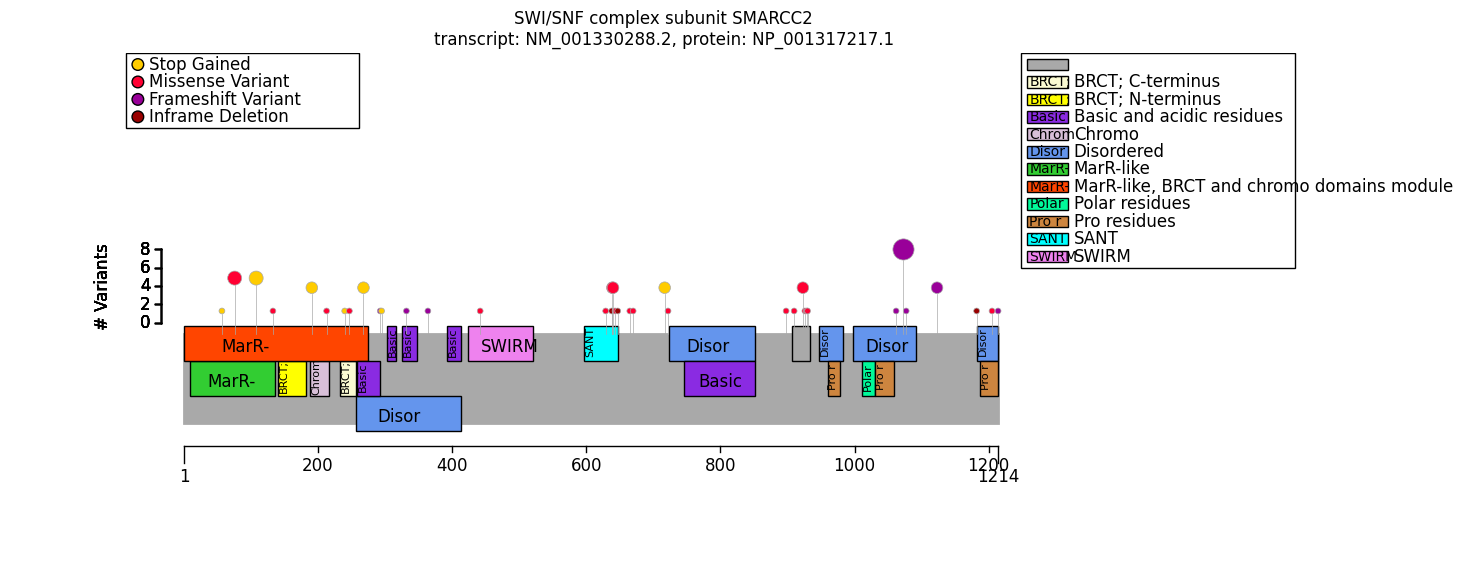

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
smarcc2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
smarcc2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
15,"MarR-like, BRCT and chromo domains module",Region,2 - 274,p.Tyr109Ter; p.Pro77Leu; p.Gln58Ter; p.Phe248Ser; p.Thr214Ala; p.Arg192Ter; p.Trp241Ter; p.Arg269Ter; p.Asn134Asp
8,MarR-like,Domain,11 - 136,p.Tyr109Ter; p.Gln58Ter; p.Pro77Leu; p.Asn134Asp
0,BRCT; N-terminus,Domain,141 - 183,
3,Chromo,Domain,190 - 217,p.Thr214Ala; p.Arg192Ter
2,BRCT; C-terminus,Domain,234 - 257,p.Trp241Ter; p.Phe248Ser
6,Disordered,Region,258 - 413,p.Lys365ThrfsTer12; p.Arg269Ter; p.Gly294LysfsTer3; p.Tyr296Ter; p.Glu334ArgfsTer49
2,Basic and acidic residues,Compositional bias,259 - 292,p.Arg269Ter
0,Basic and acidic residues,Compositional bias,304 - 317,
1,Basic and acidic residues,Compositional bias,327 - 348,p.Glu334ArgfsTer49
0,Basic and acidic residues,Compositional bias,394 - 413,


## Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_effect, anyof
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
nonsense = variant_effect(VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
frameshift = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
truncating = anyof((nonsense, frameshift))

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=truncating,
    a_label="Missense",
    b_label="Truncating"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,73
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,56
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,150


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                     Missense         Truncating  \
                                                    Count Percent      Count   
Moderate global developmental delay [HP:0011343]    10/23     43%       1/23   
Mild global developmental delay [HP:0011342]         6/23     26%      14/23   
Intellectual disability [HP:0001249]                22/23     96%      17/23   
Hypotonia [HP:0001252]                              18/23     78%      13/23   
Thin upper lip vermilion [HP:0000219]                8/23     35%      13/23   
Failure to thrive [HP:0001508]                      13/23     57%       8/23   
Feeding difficulties [HP:0011968]                   13/23     57%       8/21   
Autistic behavior [HP:0000729]                       7/23     30%      11/25   
Abnormal upper lip morphology [HP:0000177]          16/16    100%      17/17   
Abnormal lip morphology [HP:0000159]                16/16    100%      20/20   
Abnormal oral cavity morphology [HP:0000163]        17/17    100%      21/21   
Abnormal nasal morphology [HP:0005105]              11/11    100%      17/17   
Global developmental delay [HP:0001263]             22/22    100%      17/17   
Neurodevelopmental abnormality [HP:0012759]         22/22    100%      17/17   
Abnormal ocular adnexa morphology [HP:0030669]      16/16    100%      14/14   
Abnormality of the philtrum [HP:0000288]            12/12    100%      14/14   
Abnormal muscle tone [HP:0003808]                   18/18    100%      14/14   

Allele group                                                                 \
                                                 Percent Corrected p values   
Moderate global developmental delay [HP:0011343]      4%           0.070508   
Mild global developmental delay [HP:0011342]         61%           0.307217   
Intellectual disability [HP:0001249]                 74%           0.543524   
Hypotonia [HP:0001252]                               57%           0.596789   
Thin upper lip vermilion [HP:0000219]                57%           0.596789   
Failure to thrive [HP:0001508]                       35%           0.596789   
Feeding difficulties [HP:0011968]                    38%           0.596789   
Autistic behavior [HP:0000729]                       44%           0.814037   
Abnormal upper lip morphology [HP:0000177]          100%           1.000000   
Abnormal lip morphology [HP:0000159]                100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]        100%           1.000000   
Abnormal nasal morphology [HP:0005105]              100%           1.000000   
Global developmental delay [HP:0001263]             100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]         100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]      100%           1.000000   
Abnormality of the philtrum [HP:0000288]            100%           1.000000   
Abnormal muscle tone [HP:0003808]                   100%           1.000000   

Allele group                                                
                                                  p values  
Moderate global developmental delay [HP:0011343]  0.004148  
Mild global developmental delay [HP:0011342]      0.036143  
Intellectual disability [HP:0001249]              0.095916  
Hypotonia [HP:0001252]                            0.207811  
Thin upper lip vermilion [HP:0000219]             0.236189  
Failure to thrive [HP:0001508]                    0.236189  
Feeding difficulties [HP:0011968]                 0.245737  
Autistic behavior [HP:0000729]                    0.383076  
Abnormal upper lip morphology [HP:0000177]        1.000000  
Abnormal lip morphology [HP:0000159]              1.000000  
Abnormal oral cavity morphology [HP:0000163]      1.000000  
Abnormal nasal morphology [HP:0005105]            1.000000  
Global developmental delay [HP:0001263]           1.000000  
Neurodevelopmental abnormality [HP:0012759]       1.000000  
A

In [10]:
from gpsea.analysis.predicate import variant_key

c3222del = variant_key("12_56165327_56165328_CA_C") # c.3222del; p.Gly1075AspfsTer17

c3222del_clf = monoallelic_classifier(
    a_predicate=c3222del,
    b_predicate=~c3222del,
    a_label = "c.3222del",
    b_label="other"
)
c3222del_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=c3222del_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=c3222del_result)

Allele group                                     c.3222del          other  \
                                                     Count Percent  Count   
Intellectual disability [HP:0001249]                   1/6     17%  49/52   
Autistic behavior [HP:0000729]                         7/8     88%  13/51   
Wide nose [HP:0000445]                                 3/6     50%  11/48   
Prominent forehead [HP:0011220]                        3/6     50%  11/41   
Feeding difficulties [HP:0011968]                      2/6     33%  26/50   
Failure to thrive [HP:0001508]                         2/6     33%  26/52   
Thin upper lip vermilion [HP:0000219]                  3/6     50%  21/50   
Abnormality of upper lip vermillion [HP:0011339]       3/3    100%  24/24   
Abnormal upper lip morphology [HP:0000177]             4/4    100%  37/37   
Abnormal lip morphology [HP:0000159]                   4/4    100%  40/40   
Abnormal oral cavity morphology [HP:0000163]           4/4    100%  44/44   
Abnormal nasal morphology [HP:0005105]                 6/6    100%  30/30   
Global developmental delay [HP:0001263]                1/1    100%  49/49   
Neurodevelopmental abnormality [HP:0012759]            1/1    100%  49/49   
Abnormal eyelid morphology [HP:0000492]                1/1    100%  29/29   
Abnormal ocular adnexa morphology [HP:0030669]         3/3    100%  36/36   
Abnormality of the philtrum [HP:0000288]               3/3    100%  30/30   
Abnormal external nose morphology [HP:0010938]         2/2    100%  25/25   
Hypotonia [HP:0001252]                                 4/6     67%  36/52   
Abnormal muscle tone [HP:0003808]                      4/4    100%  38/38   
Abnormal eyebrow morphology [HP:0000534]               2/2    100%  24/24   
Abdominal symptom [HP:0011458]                         2/2    100%  26/26   
Decreased body weight [HP:0004325]                     2/2    100%  29/31   
Abnormal axial skeleton morphology [HP:0009121]        2/2    100%  24/24   

Allele group                                                                 \
                                                 Percent Corrected p values   
Intellectual disability [HP:0001249]                 94%           0.001677   
Autistic behavior [HP:0000729]                       25%           0.017042   
Wide nose [HP:0000445]                               23%           1.000000   
Prominent forehead [HP:0011220]                      27%           1.000000   
Feeding difficulties [HP:0011968]                    52%           1.000000   
Failure to thrive [HP:0001508]                       50%           1.000000   
Thin upper lip vermilion [HP:0000219]                42%           1.000000   
Abnormality of upper lip vermillion [HP:0011339]    100%           1.000000   
Abnormal upper lip morphology [HP:0000177]          100%           1.000000   
Abnormal lip morphology [HP:0000159]                100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]        100%           1.000000   
Abnormal nasal morphology [HP:0005105]              100%           1.000000   
Global developmental delay [HP:0001263]             100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]         100%           1.000000   
Abnormal eyelid morphology [HP:0000492]             100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]      100%           1.000000   
Abnormality of the philtrum [HP:0000288]            100%           1.000000   
Abnormal external nose morphology [HP:0010938]      100%           1.000000   
Hypotonia [HP:0001252]                               69%           1.000000   
Abnormal muscle tone [HP:0003808]                   100%           1.000000   
Abnormal eyebrow morphology [HP:0000534]            100%           1.000000   
Abdominal symptom [HP:0011458]                      100%           1.000000   
Decreased body weight [HP:0004325]                   94%           1.000000   
Abnormal axial skeleto

## Correlation of **Region 1 - 274: MarR-like, BRCT and chromo domains module vs Other Regions**

In [11]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

nterm_region = Region(start=1, end=274)
is_n_term = protein_region(region=nterm_region, tx_id=mane_tx_id)

nterm_clf = monoallelic_classifier(
    a_predicate=is_n_term,
    b_predicate=~ is_n_term,
    a_label ="N term",
    b_label = "Other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                     N term          Other  \
                                                  Count Percent  Count   
Mild global developmental delay [HP:0011342]      11/15     73%  10/43   
Hypotonia [HP:0001252]                             7/15     47%  33/43   
Thin upper lip vermilion [HP:0000219]              9/15     60%  15/41   
Failure to thrive [HP:0001508]                     5/15     33%  23/43   
Feeding difficulties [HP:0011968]                  5/14     36%  23/42   
Thick eyebrow [HP:0000574]                         4/15     27%  17/41   
Decreased body weight [HP:0004325]                  6/7     86%  25/26   
Intellectual disability [HP:0001249]              14/15     93%  36/43   
Abnormality of upper lip vermillion [HP:0011339]    9/9    100%  18/18   
Abnormal upper lip morphology [HP:0000177]        11/11    100%  30/30   
Abnormal lip morphology [HP:0000159]              12/12    100%  32/32   
Abnormal oral cavity morphology [HP:0000163]      13/13    100%  35/35   
Abnormal nasal morphology [HP:0005105]              7/7    100%  29/29   
Global developmental delay [HP:0001263]           14/14    100%  36/36   
Neurodevelopmental abnormality [HP:0012759]       14/14    100%  36/36   
Abnormal eyelid morphology [HP:0000492]             7/7    100%  23/23   
Abnormal ocular adnexa morphology [HP:0030669]      9/9    100%  30/30   
Abnormality of the philtrum [HP:0000288]            9/9    100%  24/24   
Abnormal external nose morphology [HP:0010938]      7/7    100%  20/20   
Abnormal muscle tone [HP:0003808]                   8/8    100%  34/34   
Abnormal eyebrow morphology [HP:0000534]            6/6    100%  20/20   
Abdominal symptom [HP:0011458]                      5/5    100%  23/23   
Abnormal axial skeleton morphology [HP:0009121]     6/6    100%  20/20   

Allele group                                                                 \
                                                 Percent Corrected p values   
Mild global developmental delay [HP:0011342]         23%           0.027121   
Hypotonia [HP:0001252]                               77%           0.576792   
Thin upper lip vermilion [HP:0000219]                37%           1.000000   
Failure to thrive [HP:0001508]                       53%           1.000000   
Feeding difficulties [HP:0011968]                    55%           1.000000   
Thick eyebrow [HP:0000574]                           41%           1.000000   
Decreased body weight [HP:0004325]                   96%           1.000000   
Intellectual disability [HP:0001249]                 84%           1.000000   
Abnormality of upper lip vermillion [HP:0011339]    100%           1.000000   
Abnormal upper lip morphology [HP:0000177]          100%           1.000000   
Abnormal lip morphology [HP:0000159]                100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]        100%           1.000000   
Abnormal nasal morphology [HP:0005105]              100%           1.000000   
Global developmental delay [HP:0001263]             100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]         100%           1.000000   
Abnormal eyelid morphology [HP:0000492]             100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]      100%           1.000000   
Abnormality of the philtrum [HP:0000288]            100%           1.000000   
Abnormal external nose morphology [HP:0010938]      100%           1.000000   
Abnormal muscle tone [HP:0003808]                   100%           1.000000   
Abnormal eyebrow morphology [HP:0000534]            100%           1.000000   
Abdominal symptom [HP:0011458]                      100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]     100%           1.000000   

Allele group                                                
                                                  p values  
Mild global developmental delay [HP:0011342]      0

In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                              FEMALE           MALE  \
                                                  Count Percent  Count   
Wide nose [HP:0000445]                             9/21     43%   5/33   
Mild global developmental delay [HP:0011342]      12/23     52%   9/35   
Thick nasal alae [HP:0009928]                      9/21     43%   6/33   
Autistic behavior [HP:0000729]                     4/22     18%  16/37   
Thick eyebrow [HP:0000574]                        11/22     50%  10/34   
Decreased body weight [HP:0004325]                12/14     86%  19/19   
Intellectual disability [HP:0001249]              21/23     91%  29/35   
Failure to thrive [HP:0001508]                    10/23     43%  18/35   
Hypotonia [HP:0001252]                            15/23     65%  25/35   
Thin upper lip vermilion [HP:0000219]             10/22     45%  14/34   
Abnormality of upper lip vermillion [HP:0011339]  10/10    100%  17/17   
Abnormal upper lip morphology [HP:0000177]        17/17    100%  24/24   
Abnormal lip morphology [HP:0000159]              19/19    100%  25/25   
Abnormal oral cavity morphology [HP:0000163]      22/22    100%  26/26   
Abnormal nasal morphology [HP:0005105]            20/20    100%  16/16   
Global developmental delay [HP:0001263]           21/21    100%  29/29   
Neurodevelopmental abnormality [HP:0012759]       21/21    100%  29/29   
Abnormal eyelid morphology [HP:0000492]           11/11    100%  19/19   
Abnormal ocular adnexa morphology [HP:0030669]    15/15    100%  24/24   
Abnormality of the philtrum [HP:0000288]          14/14    100%  19/19   
Abnormal external nose morphology [HP:0010938]    16/16    100%  11/11   
Abnormal muscle tone [HP:0003808]                 15/15    100%  27/27   
Abnormal eyebrow morphology [HP:0000534]          11/11    100%  15/15   
Feeding difficulties [HP:0011968]                 10/21     48%  18/35   
Abdominal symptom [HP:0011458]                    10/10    100%  18/18   
Abnormal axial skeleton morphology [HP:0009121]   11/11    100%  15/15   

Sex                                                                          \
                                                 Percent Corrected p values   
Wide nose [HP:0000445]                               15%           0.562497   
Mild global developmental delay [HP:0011342]         26%           0.562497   
Thick nasal alae [HP:0009928]                        18%           0.562497   
Autistic behavior [HP:0000729]                       43%           0.562497   
Thick eyebrow [HP:0000574]                           29%           0.746843   
Decreased body weight [HP:0004325]                  100%           0.746843   
Intellectual disability [HP:0001249]                 83%           1.000000   
Failure to thrive [HP:0001508]                       51%           1.000000   
Hypotonia [HP:0001252]                               71%           1.000000   
Thin upper lip vermilion [HP:0000219]                41%           1.000000   
Abnormality of upper lip vermillion [HP:0011339]    100%           1.000000   
Abnormal upper lip morphology [HP:0000177]          100%           1.000000   
Abnormal lip morphology [HP:0000159]                100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]        100%           1.000000   
Abnormal nasal morphology [HP:0005105]              100%           1.000000   
Global developmental delay [HP:0001263]             100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]         100%           1.000000   
Abnormal eyelid morphology [HP:0000492]             100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]      100%           1.000000   
Abnormality of the philtrum [HP:0000288]            100%           1.000000   
Abnormal external nose morphology [HP:0010938]      100%           1.000000   
Abnormal muscle tone [HP:0003808]                   100%           1.000000   
Abnormal eyebrow morphology [HP

## Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=c3222del_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol, 
    cohort=cohort, 
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer

summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=smarcc2_fig)

Figure saved to ../../supplement/img/SMARCC2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SMARCC2_summary_draft.tex


*-* EOF *-*